In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import matplotlib.transforms as mtransforms
import datetime
import math

In [2]:
def gather_data(data_codes, start, 
                end = datetime.datetime.today(), freq = "M"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

In [3]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }
               
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
fed_data = gather_data(data_codes = data_codes, start = start, 
                   end = end, freq = "M")

In [4]:
stock_data = web.DataReader('^GSPC', 'yahoo', start, end)

In [5]:
stock_data

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971
...,...,...,...,...,...,...
2021-11-17,4701.500000,4684.410156,4701.500000,4688.669922,3221250000,4688.669922
2021-11-18,4708.799805,4672.779785,4700.720215,4704.540039,3335620000,4704.540039
2021-11-19,4717.750000,4694.220215,4708.439941,4697.959961,3265600000,4697.959961


In [6]:
fed_data

,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: Deposits from Dep. Institutions ($ Mil),Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil)
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-31,601900.0,594.67875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.40850,NaN,5.500000,NaN,5.448387,NaN,72445.0,39.064
2000-02-29,578000.0,566.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.24300,NaN,5.741379,NaN,5.734828,NaN,69823.5,37.022
2000-03-31,577100.0,563.70500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.20940,NaN,5.838710,NaN,5.853548,NaN,49108.4,33.233
2000-04-30,578600.0,564.73350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.26750,NaN,6.000000,NaN,6.019667,NaN,46876.0,33.508
2000-05-31,580600.0,565.83560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.25060,NaN,6.258065,NaN,6.268065,NaN,44636.4,33.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,6041900.0,2167.93400,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,...,3883067.75,862533.00,380.02900,5142879.50,NaN,0.25,0.058065,0.100000,NaN,NaN
2021-06-30,6027000.0,2178.84320,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,...,3789613.40,767312.40,332.96560,4906226.60,NaN,0.25,0.078000,0.123333,NaN,NaN
2021-07-31,6130200.0,2186.12825,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,...,3944127.75,633925.00,243.89825,4831987.25,NaN,0.25,0.098065,0.150000,NaN,NaN


In [7]:
df_merged = fed_data.merge(stock_data, how='left', left_index=True, right_index=True)   #Left join based on the index (Dates)

In [8]:
df_merged = fed_data.merge(stock_data, how='left', left_index=True, right_index=True)   #Left join based on the index (Dates)
df_merged = df_merged.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1)
df_merged

,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil),Adj Close
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-31,601900.0,594.67875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.40850,NaN,5.500000,NaN,5.448387,NaN,72445.0,39.064,1394.459961
2000-02-29,578000.0,566.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.24300,NaN,5.741379,NaN,5.734828,NaN,69823.5,37.022,1366.420044
2000-03-31,577100.0,563.70500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.20940,NaN,5.838710,NaN,5.853548,NaN,49108.4,33.233,1498.579956
2000-04-30,578600.0,564.73350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.26750,NaN,6.000000,NaN,6.019667,NaN,46876.0,33.508,NaN
2000-05-31,580600.0,565.83560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.25060,NaN,6.258065,NaN,6.268065,NaN,44636.4,33.894,1420.599976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,6041900.0,2167.93400,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,...,862533.00,380.02900,5142879.50,NaN,0.25,0.058065,0.100000,NaN,NaN,NaN
2021-06-30,6027000.0,2178.84320,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,...,767312.40,332.96560,4906226.60,NaN,0.25,0.078000,0.123333,NaN,NaN,4297.500000
2021-07-31,6130200.0,2186.12825,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,...,633925.00,243.89825,4831987.25,NaN,0.25,0.098065,0.150000,NaN,NaN,NaN


In [9]:
df_merged

,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil),Adj Close
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-31,601900.0,594.67875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.40850,NaN,5.500000,NaN,5.448387,NaN,72445.0,39.064,1394.459961
2000-02-29,578000.0,566.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.24300,NaN,5.741379,NaN,5.734828,NaN,69823.5,37.022,1366.420044
2000-03-31,577100.0,563.70500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.20940,NaN,5.838710,NaN,5.853548,NaN,49108.4,33.233,1498.579956
2000-04-30,578600.0,564.73350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.26750,NaN,6.000000,NaN,6.019667,NaN,46876.0,33.508,NaN
2000-05-31,580600.0,565.83560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.25060,NaN,6.258065,NaN,6.268065,NaN,44636.4,33.894,1420.599976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,6041900.0,2167.93400,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,...,862533.00,380.02900,5142879.50,NaN,0.25,0.058065,0.100000,NaN,NaN,NaN
2021-06-30,6027000.0,2178.84320,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,...,767312.40,332.96560,4906226.60,NaN,0.25,0.078000,0.123333,NaN,NaN,4297.500000
2021-07-31,6130200.0,2186.12825,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,...,633925.00,243.89825,4831987.25,NaN,0.25,0.098065,0.150000,NaN,NaN,NaN


In [10]:
df_merged.to_csv("merged.csv")

In [11]:
df_merged.isnull().sum()

Base: Total ($ Mil)                                                0
Base: Currency in Circulation ($ Mil)                              0
Balance Sheet: Total Assets ($ Mil)                               35
Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)     35
Balance Sheet: Securities Held Outright ($ Mil)                   35
Balance Sheet: U.S. Treasuries Held Outright ($ Mil)              35
Balance Sheet: Federal Agency Debt Securities ($ Mil)             35
Balance Sheet: Mortgage-Backed Securities ($ Mil)                 35
Balance Sheet: Repos ($ Mil)                                      35
Balance Sheet: Central Bank Liquidity Swaps ($ Mil)               35
Balance Sheet: Direct Lending ($ Mil)                             35
Balance Sheet: Unamortized Security Premiums ($ Mil)              35
Balance Sheet: Total Liabilities ($ Mil)                          35
Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)          35
Balance Sheet: Reverse Repos ($ Mi

In [12]:
## create a list of missing value

df_merged.dropna()

,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil),Adj Close
DATE,,,,,,,,,,,,,,,,,,,,,
2008-12-31,1666400.0,877.8834,2222737.4,1233658.0,493252.8,476134.6,17118.2,0.0,80000.0,555797.0,...,88723.0,13.574,1239918.2,1.0,0.25,0.155161,0.612903,55895.0,37.245,903.25


In [13]:
data_codes  = {"Base: Currency in Circulation ($ Mil)": "WCURCIR",
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Effective Federal Funds Rate":"DFF"}

start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
fed_data = gather_data(data_codes = data_codes, start = start, 
                   end = end, freq = "M")

In [14]:
fed_data

,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate
DATE,,,
2000-01-31,594.678750,NaN,5.448387
2000-02-29,566.143750,NaN,5.734828
2000-03-31,563.705000,NaN,5.853548
2000-04-30,564.733500,NaN,6.019667
2000-05-31,565.835600,NaN,6.268065
...,...,...,...
2021-07-31,2186.128250,8.190357e+06,0.098065
2021-08-31,2187.632750,8.291893e+06,0.092258
2021-09-30,2194.903000,8.418612e+06,0.079333


In [15]:
df_merged = fed_data.merge(stock_data, how='left', left_index=True, right_index=True)   #Left join based on the index (Dates)

In [16]:
df_merged = df_merged.drop(['High', 'Low', 'Open', 'Close', 'Volume'], axis=1)

In [17]:
df_merged

,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate,Adj Close
DATE,,,,
2000-01-31,594.678750,NaN,5.448387,1394.459961
2000-02-29,566.143750,NaN,5.734828,1366.420044
2000-03-31,563.705000,NaN,5.853548,1498.579956
2000-04-30,564.733500,NaN,6.019667,NaN
2000-05-31,565.835600,NaN,6.268065,1420.599976
...,...,...,...,...
2021-07-31,2186.128250,8.190357e+06,0.098065,NaN
2021-08-31,2187.632750,8.291893e+06,0.092258,4522.680176
2021-09-30,2194.903000,8.418612e+06,0.079333,4307.540039


In [18]:
df_merged.isnull().sum()

Base: Currency in Circulation ($ Mil)     0
Balance Sheet: Total Assets ($ Mil)      35
Effective Federal Funds Rate              0
Adj Close                                79
dtype: int64

In [19]:
data_new1 = df_merged.fillna(0)                                 # Substitute NaN in all columns
print(data_new1)                                           # Print DataFrame with zeros

            Base: Currency in Circulation ($ Mil)  \
DATE                                                
2000-01-31                             594.678750   
2000-02-29                             566.143750   
2000-03-31                             563.705000   
2000-04-30                             564.733500   
2000-05-31                             565.835600   
...                                           ...   
2021-07-31                            2186.128250   
2021-08-31                            2187.632750   
2021-09-30                            2194.903000   
2021-10-31                            2202.506500   
2021-11-30                            2210.156333   

            Balance Sheet: Total Assets ($ Mil)  Effective Federal Funds Rate  \
DATE                                                                            
2000-01-31                         0.000000e+00                      5.448387   
2000-02-29                         0.000000e+00                    

In [20]:
data_new1.to_csv("datamerged.csv")

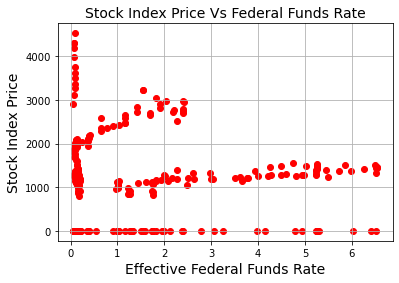

In [21]:
plt.scatter(data_new1['Effective Federal Funds Rate'], data_new1['Adj Close'], color='Red')
plt.title('Stock Index Price Vs Federal Funds Rate', fontsize=14)
plt.xlabel('Effective Federal Funds Rate', fontsize=14)
plt.ylabel('Stock Index Price', fontsize=14)
plt.grid(True)
plt.show()

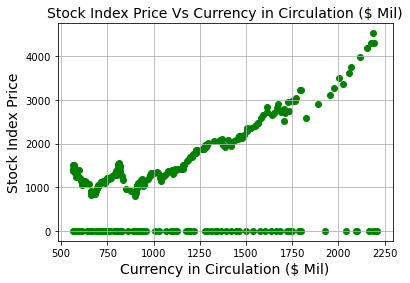

In [22]:
plt.scatter(data_new1['Base: Currency in Circulation ($ Mil)'], data_new1['Adj Close'], color='Green')
plt.title('Stock Index Price Vs Currency in Circulation ($ Mil)', fontsize=14)
plt.xlabel('Currency in Circulation ($ Mil)', fontsize=14)
plt.ylabel('Stock Index Price', fontsize=14)
plt.grid(True)
plt.show()

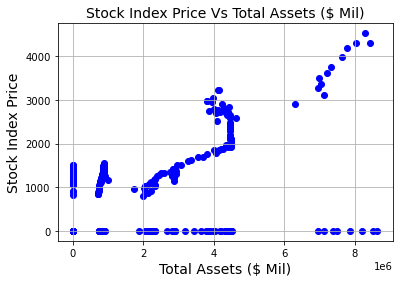

In [23]:
plt.scatter(data_new1['Balance Sheet: Total Assets ($ Mil)'], data_new1['Adj Close'], color='Blue')
plt.title('Stock Index Price Vs Total Assets ($ Mil)', fontsize=14)
plt.xlabel('Total Assets ($ Mil)', fontsize=14)
plt.ylabel('Stock Index Price', fontsize=14)
plt.grid(True)
plt.show()

In [24]:
# to check the correlationship

corr = data_new1.corr()
print(corr)

                                       Base: Currency in Circulation ($ Mil)  \
Base: Currency in Circulation ($ Mil)                               1.000000   
Balance Sheet: Total Assets ($ Mil)                                 0.960467   
Effective Federal Funds Rate                                       -0.487604   
Adj Close                                                           0.446740   

                                       Balance Sheet: Total Assets ($ Mil)  \
Base: Currency in Circulation ($ Mil)                             0.960467   
Balance Sheet: Total Assets ($ Mil)                               1.000000   
Effective Federal Funds Rate                                     -0.608471   
Adj Close                                                         0.400649   

                                       Effective Federal Funds Rate  Adj Close  
Base: Currency in Circulation ($ Mil)                     -0.487604   0.446740  
Balance Sheet: Total Assets ($ Mil)           

<AxesSubplot:>

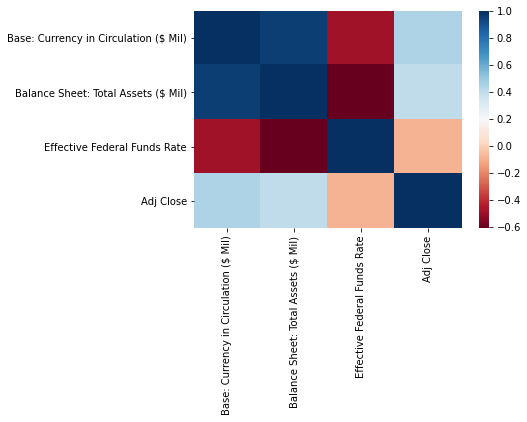

In [25]:
# we will plot a heatmap for visualization of correlation matrix

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

#RdBu is actually colors= Red, Blue

DATA BEFORE
----------------------------------------------------------------------------------------------------


const                                    24.899981
Base: Currency in Circulation ($ Mil)    16.417858
Balance Sheet: Total Assets ($ Mil)      19.333726
Effective Federal Funds Rate              2.001385
Adj Close                                 1.289087
dtype: float64

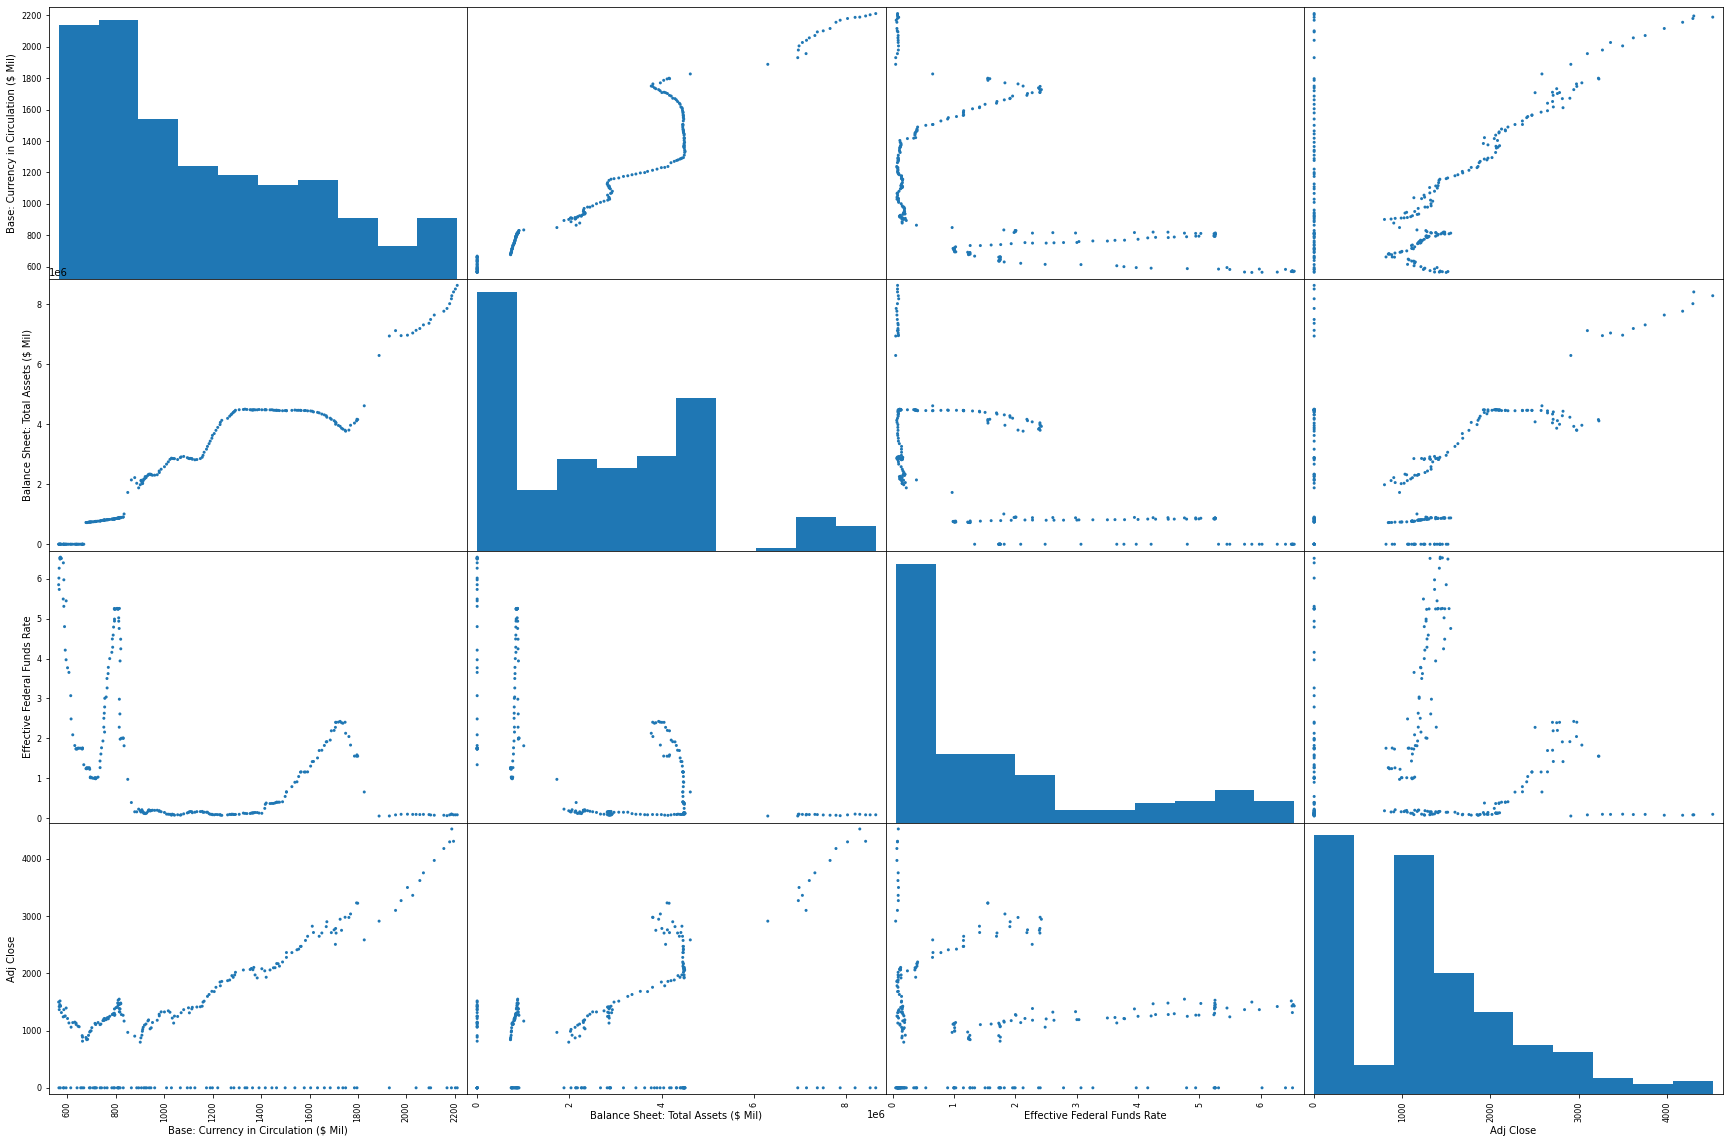

In [26]:
#multicolliearity

data_before = data_new1
X1 = sm.tools.add_constant(data_before)

series_before = pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], index=X1.columns)

print('DATA BEFORE')
print('-'*100)
display(series_before)

pd.plotting.scatter_matrix(data_before, alpha = 1, figsize = (30,20))

plt.show()

In [28]:
# get the summary
desc_df = data_new1.describe()

# add the standard deviation metric
desc_df.loc['+3_std'] = desc_df.loc['mean'] + (desc_df.loc['std'] * 3)
desc_df.loc['-3_std'] = desc_df.loc['mean'] - (desc_df.loc['std'] * 3)

# display it
desc_df

,Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),Effective Federal Funds Rate,Adj Close
count,263.000000,2.630000e+02,263.000000,263.000000
mean,1123.923417,2.666809e+06,1.648401,1213.280379
std,448.894755,2.142331e+06,1.887175,1036.881780
min,563.705000,0.000000e+00,0.049000,0.000000
25%,761.671600,8.138925e+05,0.131290,0.000000
50%,978.912500,2.392692e+06,1.007241,1211.920044
75%,1454.251650,4.388674e+06,2.384317,1769.565002
max,2210.156333,8.637653e+06,6.544516,4522.680176
+3_std,2470.607682,9.093802e+06,7.309925,4323.925717
-3_std,-222.760849,-3.760184e+06,-4.013123,-1897.364960


Filtering the Dataset
To drop or not to drop, that is the question. Generally, if we believe the data has been entered in error, we should remove it. However, in this situation, the values that are being identified as outliers are correct values and are not errors. Both of these values were produced during specific moments in time. The one in 1998 was right after the Asian Financial Crisis, and the one in 2001 is right after the DotCom Bubble, so it's entirely conceivable that these values were produced in extreme albeit rare conditions. For this reason, I will NOT be removing these values from the dataset as they recognize actual values that took place.

Imagine if we wanted to remove the values that have an amount exceeding three standard deviations. How would we approach this? Well, if we leverage the numpy module and the scipy module we can filter out the rows using the stats.zscore function. The Z-score is the number of standard deviations from the mean a data point is, so if it's less than 3 we keep it otherwise we drop it. From here, I also provided a way to let us know what rows were removed by using the index.difference the function which will show the difference between the two datasets.

In [29]:
# filter the data frame to remove the values exceeding 3 standard deviations
data_new_df = data_new1[(np.abs(stats.zscore(data_new1)) < 3).all(axis=1)]

# what rows were removed
data_new1.index.difference(data_new_df.index)

DatetimeIndex(['2021-08-31'], dtype='datetime64[ns]', name='DATE', freq=None)

Section Five: Build the Model

In [ ]:
In our example, you may want to check that a linear relationship exists between the:

Stock_Index_Price (dependent variable) and Interest_Rate (independent variable)
Stock_Index_Price (dependent variable) and Unemployment_Rate (independent variable)